In [1]:
using Revise
includet("../../scripts/single_influx.jl")

In [2]:
using GLMakie
using CairoMakie
CairoMakie.activate!()

xx = LeakageScale.ltox(0.999) = 6.906754778648553


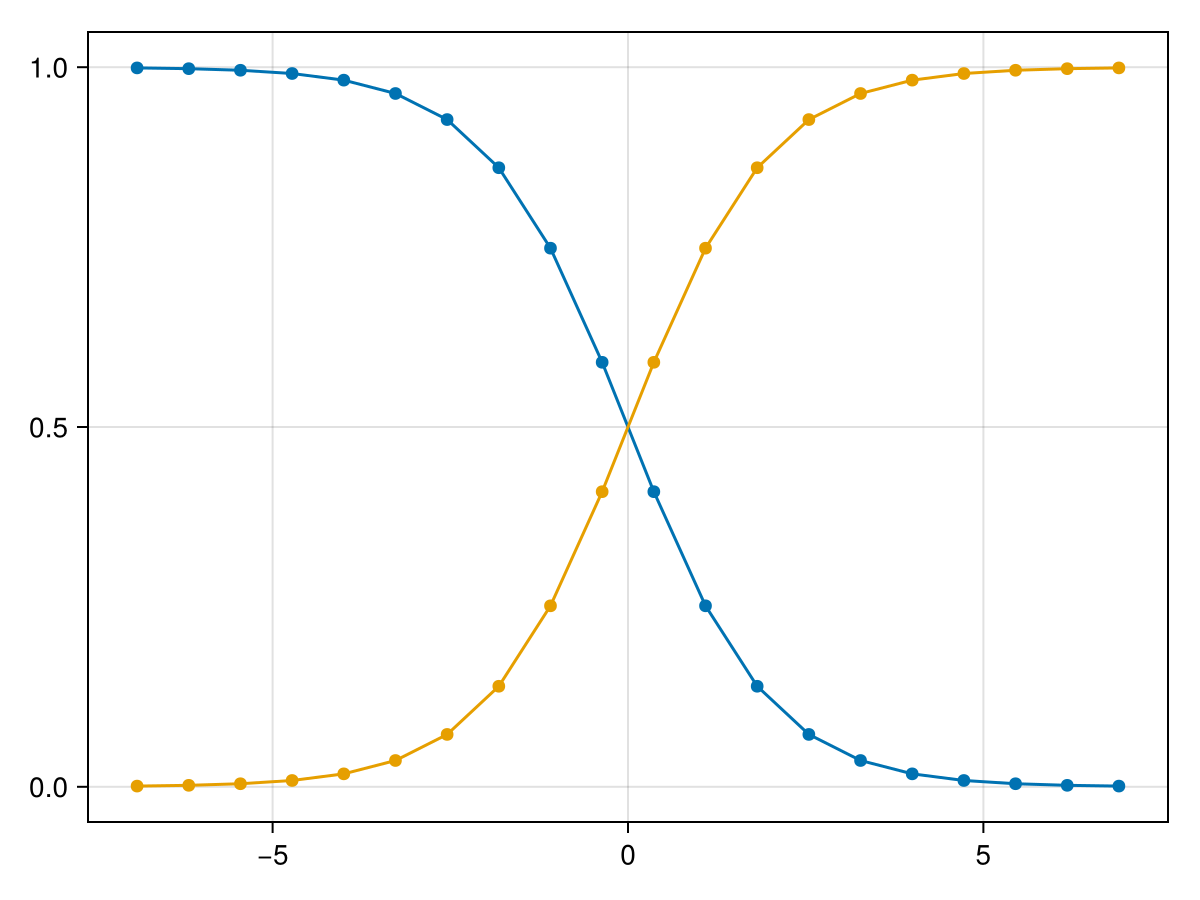

In [46]:
@show xx = LeakageScale.ltox(0.999)
xs = range(-xx, xx, 20)
es = LeakageScale.e.(xs)
fap = scatterlines(xs, es)
ls = LeakageScale.l.(xs)
scatterlines!(fap.axis, xs, ls)
fap

In [6]:
gd1 = gendata1()

li = 1.0


Progress:  30%|████████████▎                            |  ETA: 0:00:20┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:393
┌ Error: maxresid reached is 0.175406 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
Progress: 100%|█████████████████████████████████████████| Time: 0:01:37


countmap(df.sscode) = Dict(2 => 151, -2000 => 1, 1 => 348)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(23 => 2, 22 => 2, 13 => 1, 2 => 191, 11 => 2, 12 => 30, 1 => 271, missing => 1)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.924
prop_good_ss_and_ls = 0.924
li = 0.9


Progress:  70%|████████████████████████████▊            |  ETA: 0:00:06┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/MzuF2/src/integrator_interface.jl:626
┌ Error: maxresid reached is 14.3389 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


countmap(df.sscode) = Dict(2 => 150, -2000 => 1, 1 => 349)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(13 => 2, 11 => 35, 2 => 1, 12 => 7, 1 => 454, missing => 1)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.91
prop_good_ss_and_ls = 0.91


"./gd1_251103_143021.jld2"